In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
# Create a Kaggle directory
!mkdir ~/.kaggle

# Copy the API token (kaggle.json) to the Kaggle directory
!cp kaggle.json ~/.kaggle/

# Set the permissions of the file to ensure it’s secure
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ihormuliar/starbucks-customer-data
!unzip starbucks-customer-data.zip

The dataset consists of three tables: offer data, customer profiles, and transaction data. These will be loaded into DataFrames named df_offer, df_customer, and df_transcript, respectively.

In [6]:
df_offer = pd.read_csv('portfolio.csv')
df_customer = pd.read_csv('profile.csv')
df_transcript = pd.read_csv('transcript.csv')

In [7]:
df_offer.head()

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
df_customer.head()

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
df_transcript.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## **Data Cleaning**

In [10]:
df_offer = df_offer.drop('Unnamed: 0', axis = 1)
df_customer = df_customer.drop('Unnamed: 0', axis = 1)
df_transcript = df_transcript.drop('Unnamed: 0', axis = 1)

In [11]:
df_offer.isna().sum()

,0
reward,0
channels,0
difficulty,0
duration,0
offer_type,0
id,0


In [12]:
df_customer.isna().sum()

,0
gender,2175
age,0
id,0
became_member_on,0
income,2175


In [13]:
df_transcript.isna().sum()

,0
person,0
event,0
value,0
time,0


In df_customer, there are 2,175 missing values in both the gender and income columns. We need to verify whether these missing values are from the same observations.

In [14]:
missing_gender = df_customer[df_customer['gender'].isna()]
missing_income = df_customer[df_customer['income'].isna()]

np.sum(missing_gender['id'] == missing_income['id'])

2175

All missing values in the gender and income columns come from the same observations.

Since income is likely a significant factor in customer behavior, we will remove observations with missing income. While this results in the loss of 12.8% of the data, which is not ideal, imputing the missing values with the mean or median would compromise the robustness of our analysis. Given that we have a sufficient number of observations, this removal should not impact our findings significantly.

In [15]:
df_customer_no_na = df_customer.dropna(subset='income').reset_index(drop = True)
df_customer_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


The `became_member_on` column contains integers and needs to be converted to datetime format.

In [16]:
df_customer_no_na['became_member_on'] = pd.to_datetime(df_customer_no_na['became_member_on'], format = '%Y%m%d')
df_customer_no_na['became_member_on']

,became_member_on
0,2017-07-15
1,2017-05-09
2,2018-04-26
3,2018-02-09
4,2017-11-11
...,...
14820,2018-06-04
14821,2018-07-13
14822,2017-01-26
14823,2016-03-07


## **Data Transformation**

Add an alias to each offer for easier recognition and reference in `df_offer`.

In [17]:
# Sort df `offers`
df_offer = df_offer.sort_values(['offer_type', 'difficulty']).reset_index(drop = True)

# Add column `offer_alias`
from string import ascii_uppercase
df_offer['offer_alias'] = [ascii_uppercase[i] for i in range(df_offer.shape[0])]
df_offer

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,F
6,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,G
7,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,I
9,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,J


For `df_transcript`, the value column contains dictionary-like strings. I will extract the keys and values into separate columns to simplify manipulation.

In [18]:
# Convert the elements in the value column from strings to dictionaries
df_transcript['value'] = df_transcript['value'].apply(eval)

In [19]:
# Extract the keys
key_column = [list(d.keys())[0] for d in df_transcript['value']]

# Extract the values
value_column = [list(d.values())[0] for d in df_transcript['value']]

# Replace `value` column with df `value_column_split`
df_transcript = df_transcript.drop('value', axis = 1)
df_transcript['dict_key'] = key_column
df_transcript['dict_value'] = value_column

df_transcript.head()

,person,event,time,dict_key,dict_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


# **Exploratory Data Analysis (EDA)**

### **Customer Profile Data**

Gender

In [20]:
print(df_customer_no_na['gender'].value_counts(), '\n', df_customer_no_na['gender'].value_counts(normalize=True))

gender
M    8484
F    6129
O     212
Name: count, dtype: int64 
 gender
M    0.572277
F    0.413423
O    0.014300
Name: proportion, dtype: float64


Age

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


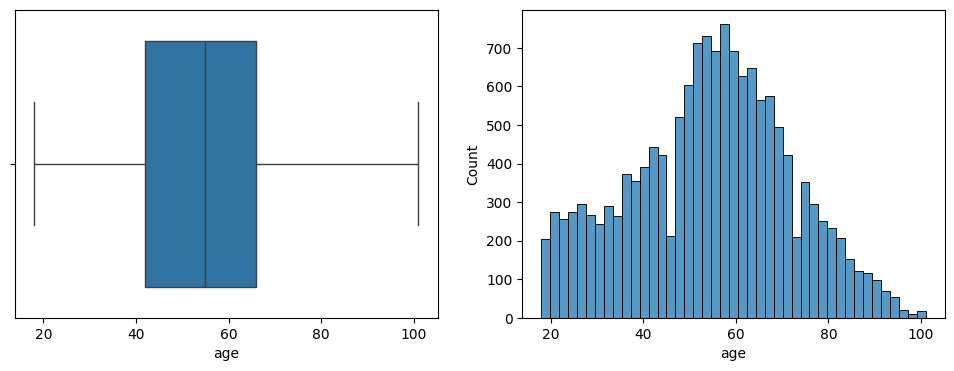

In [21]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(data = df_customer_no_na, x = 'age', ax = axs[0])
sns.histplot(data = df_customer_no_na, x = 'age', ax = axs[1])

print(df_customer_no_na['age'].describe())

- Customer ages range from 18 to 101 years, with a distribution roughly following a normal curve.
- The mean age is 54, with a standard deviation of 17.

**Divide customers into age groups**

age_group
18-25    1099
26-35    1380
36-45    2019
46-55    3262
56-65    3293
66-75    2207
76-85    1041
> 85      454
Name: count, dtype: int64


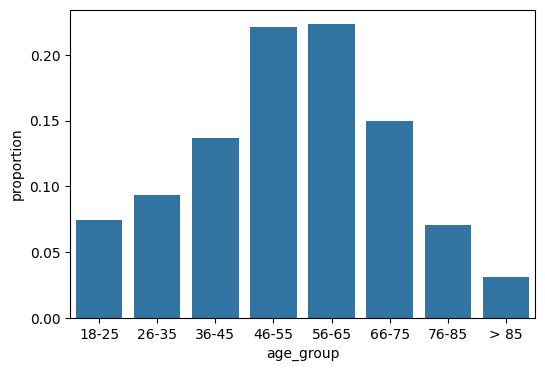

In [22]:
# Create a new column `age_group`
df_customer_no_na['age_group'] = pd.cut(df_customer_no_na['age'], \
      bins = [df_customer_no_na['age'].min(), 26, 36, 46, 56, 66, 76, 86, df_customer_no_na['age'].max()], \
      labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '> 85'])

print(df_customer_no_na['age_group'].value_counts().sort_index())

plt.figure(figsize=(6,4))
sns.barplot(df_customer_no_na['age_group'].value_counts(normalize=True).sort_index())
plt.show()

The largest age group of customers is 56-65 years old, followed closely by the 46-55 age group, with the 66-75 age group being the third largest. Together, these top 3 groups make up approximately 60% of the customer base.

This is reasonable, as individuals aged 46-75 generally have more free time compared to younger people, making them more likely to visit cafes. Additionally, they tend to have better mobility than those over 75, increasing the likelihood of being regular customers.

Income

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


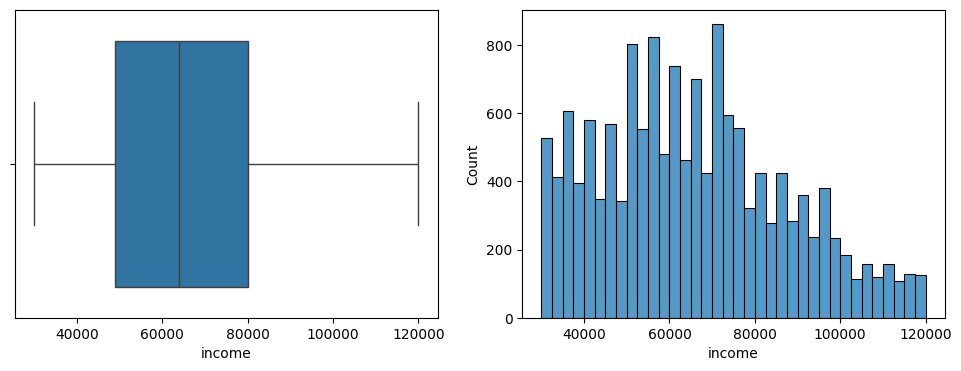

In [23]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(data = df_customer_no_na, x = 'income', ax = axs[0])
sns.histplot(data = df_customer_no_na, x = 'income', ax = axs[1])

print(df_customer_no_na['income'].describe())

**Divide customers into income groups**

income_group
30-45k     2977
45-60k     3628
60-75k     3777
75-90k     2161
90-105k    1456
> 105k      738
Name: count, dtype: int64


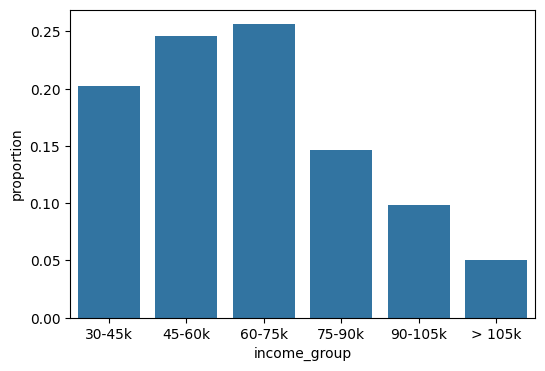

In [24]:
# Create a new column `age_group`
df_customer_no_na['income_group'] = pd.cut(df_customer_no_na['income'], \
      bins = [df_customer_no_na['income'].min(), 45000, 60000, 75000, 90000, 105000, df_customer_no_na['income'].max()], \
      labels = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k'])

print(df_customer_no_na['income_group'].value_counts().sort_index())

plt.figure(figsize=(6,4))
sns.barplot(df_customer_no_na['income_group'].value_counts(normalize=True).sort_index())
plt.show()

Customer incomes range from 30k to 120k, with an average of 65.4k. The two largest income groups are those earning 60-75k and 45-60k annually, together accounting for about 50% of the customer base.

This income distribution likely aligns with that of the general population, though individuals with very low incomes may find regular cafe visits unaffordable, while those with very high incomes may opt for alternative ways to enjoy their coffee.

became_member_on

In [25]:
# Create a new dataframe focusing on the time when customers became members
df_member = df_customer_no_na[['id', 'became_member_on']]

# Add columns `year`, `month`, `quarter`
df_member = df_member.assign(year = df_member.became_member_on.dt.year,
                             month = df_member.became_member_on.dt.month,
                             month_name = df_member.became_member_on.dt.month_name(),
                             month_year = df_member.became_member_on.dt.to_period('M'),
                             quarter_year = df_member.became_member_on.dt.to_period('Q'))

df_member.head()

,id,became_member_on,year,month,month_name,month_year,quarter_year
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,July,2017-07,2017Q3
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,5,May,2017-05,2017Q2
2,e2127556f4f64592b11af22de27a7932,2018-04-26,2018,4,April,2018-04,2018Q2
3,389bc3fa690240e798340f5a15918d5c,2018-02-09,2018,2,February,2018-02,2018Q1
4,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,2017,11,November,2017-11,2017Q4


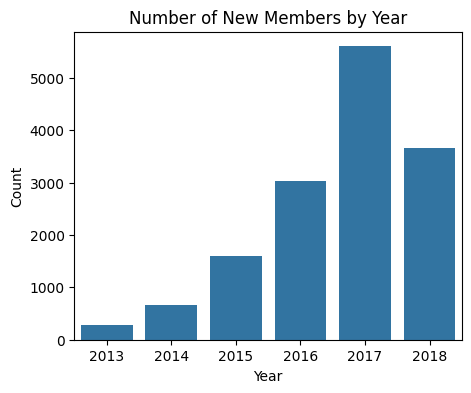

In [26]:
plt.figure(figsize=(5,4))
sns.countplot(data = df_member, x = 'year')
plt.title('Number of New Members by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [27]:
print(df_member['month_year'].min(), df_member['month_year'].max())

2013-07 2018-07


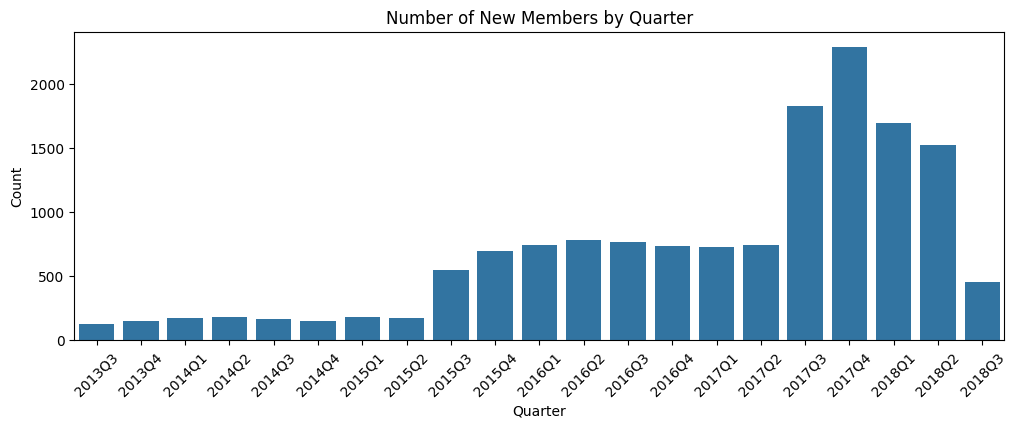

In [28]:
plt.figure(figsize=(12,4))
# sns.countplot(data = df_member, x = 'month_year')
sns.barplot(df_member['quarter_year'].value_counts().sort_index(ascending=True))
plt.title('Number of New Members by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The data contains customers became members between July 2013 and July 2018.
- Very few customers joined between 2013 and mid-2015.
- Membership growth began to rise from mid-2015 and experienced a significant surge starting in mid-2017, indicating that the company likely ran successful campaigns around mid-2015 and mid-2017, which drastically boosted member growth.
- However, starting in early 2018, the number of new members dropped by approximately 33.7%, from 2,295 in Q4 2017 to 1,522 in Q2 2018. This decline suggests that new strategies or campaigns may not have sustained the growth momentum.

**Bivariate Analysis - age vs gender**

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64


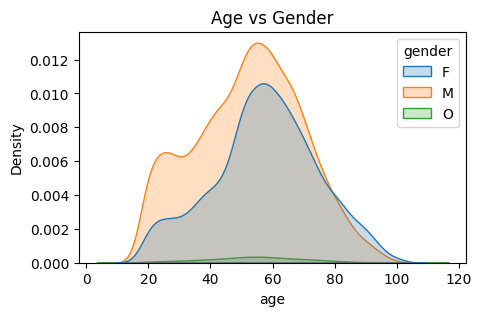

In [29]:
print(df_customer_no_na.groupby('gender')['age'].mean())
plt.figure(figsize=(5,3))
sns.kdeplot(data = df_customer_no_na, x = 'age', hue = 'gender', fill = True)
plt.title('Age vs Gender')
plt.show()

- The gender distribution of male and female customers also follows a normal pattern. However, there is a higher proportion of younger customers among males compared to females.

**Bivariate Analysis - income vs gender**

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64


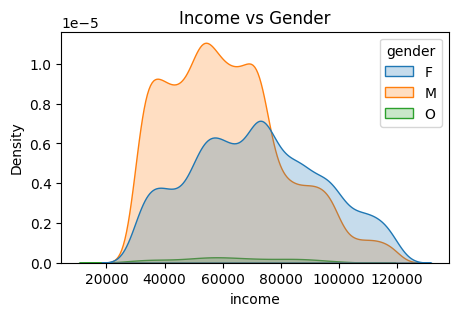

In [30]:
print(df_customer_no_na.groupby('gender')['income'].mean())
plt.figure(figsize=(5,3))
sns.kdeplot(data = df_customer_no_na, x = 'income', hue = 'gender', fill = True)
plt.title('Income vs Gender')
plt.show()

- The income distribution for female customers roughly follows a normal curve, suggesting that women across all income levels enjoy the company’s products.
- In contrast, the income distribution for male customers is right-skewed, indicating that a larger proportion of male customers fall on the lower end of the income spectrum.
- Female customers also have a significantly higher average income than other gender groups, which may be because they tend to be older on average, assuming that older customers generally have higher incomes.

**Bivariate Analysis - income vs age**

age_group
18-25    50924.476797
26-35    51168.840580
36-45    59424.467558
46-55    69203.862661
56-65    70026.116004
66-75    70690.530131
76-85    72256.484150
> 85     70449.339207
Name: income, dtype: float64


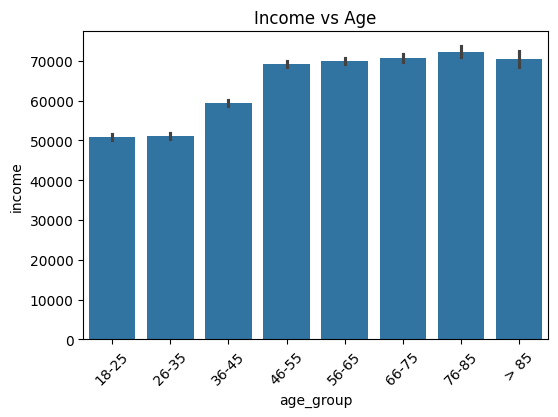

In [31]:
print(df_customer_no_na.groupby('age_group')['income'].mean())

plt.figure(figsize=(6,4))
sns.barplot(data = df_customer_no_na, x = 'age_group', y = 'income')
plt.xticks(rotation = 45)
plt.title('Income vs Age')
plt.show()

- Customers in the younger age groups (18-35 years old) have an average annual income of around 51k.
- The middle age groups (36-55 years old) have a higher average income of approximately 65k.
- For customers aged 56 and above, the average annual income is consistently around 70k. This shows that, on average, the company’s older customers tend to have higher incomes.

### **Offer Data**

Pairplots of the numerical variables — reward, difficulty, and duration — with `offer_type` represented by color

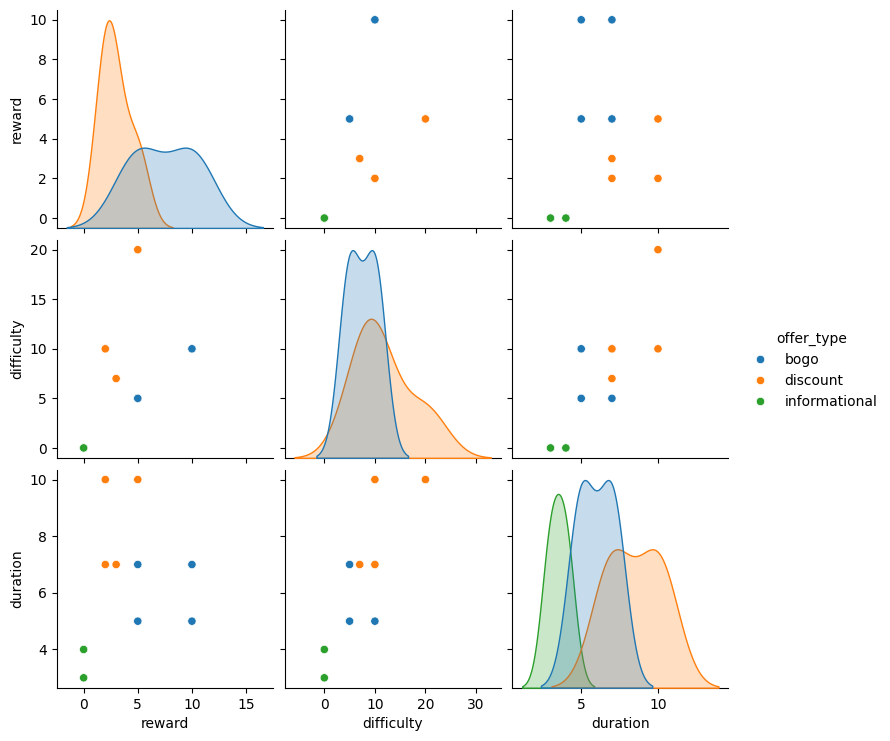

In [32]:
sns.pairplot(df_offer, hue = 'offer_type')
plt.show()

- There are 4 'bogo' offers (buy one get one), 4 'discount' offers and 2 'informational' offers.
- 'Discount' offers generally have the longest duration, followed by 'bogo' offers.
- While 'discount' offers tend to have higher difficulty, they offer lower rewards compared to 'bogo' offers.
- There appears to be a positive correlation between offer difficulty and reward.
- Additionally, offer duration seems to be negatively correlated with reward and positively correlated with difficulty.

In [33]:
df_offer.value_counts('channels')

,count
channels,
"['web', 'email', 'mobile', 'social']",4
"['web', 'email', 'mobile']",3
"['email', 'mobile', 'social']",2
"['web', 'email']",1


Offers were distributed to customers using combinations of 4 promotion channels: websites, email, mobile app, and social media. The 10 offers utilize 4 different channel combinations. The promotional effect of each channel can be analyzed by comparing the performance of offers that use different channels.

### **Transcripts Data**

In [34]:
df_transcript['event'].value_counts()

,count
event,
transaction,138953
offer received,76277
offer viewed,57725
offer completed,33579


The dataset contains approximately 140,000 transactions, which is over 4 times the number of offers completed, indicating that many customers made multiple purchases without using an offer. This suggests strong customer loyalty, which is expected because products of Starbucks are mainly coffee and food.

During the campaign month, customers received about 76,000 offers, with 76% of these offers being viewed. This relatively high view rate indicates significant customer engagement. Of the offers viewed, roughly 33,600 were completed, representing 58% of the viewed offers. This high completion rate further demonstrates strong customer loyalty, likely due to a substantial number of regular customers.

In [35]:
# Add column `days_since_start`
df_transcript['days_since_start'] = (df_transcript['time']/24)
df_transcript['days_since_start'] = df_transcript['days_since_start'].astype({'days_since_start': 'int64'})

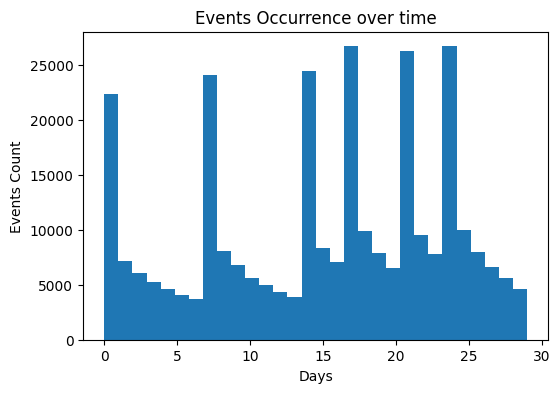

In [36]:
plt.figure(figsize=(6,4))
plt.hist(df_transcript['days_since_start'], bins = 30)
plt.xlabel('Days')
plt.ylabel('Events Count')
plt.title('Events Occurrence over time')
plt.show()

It can be seen from the plot that there were 6 peaks of events during the campaign. These peaks should correspond to offers being received, while other events (offers viewed, offers completed and purchases) occured afterwards over time.

**`event` over time - A break-down**

In [37]:
# Find how many events occurred in each hour
viewed_hourly = df_transcript[df_transcript['event'] == 'offer viewed'].value_counts('time').sort_index()
completed_hourly = df_transcript[df_transcript['event'] == 'offer completed'].value_counts('time').sort_index()
transaction_hourly = df_transcript[df_transcript['event'] == 'transaction'].value_counts('time').sort_index()

In [38]:
# Find how many events occurred on each day from Day 0 to Day 29
viewed_daily = df_transcript[df_transcript['event'] == 'offer viewed'].value_counts('days_since_start').sort_index()
completed_daily = df_transcript[df_transcript['event'] == 'offer completed'].value_counts('days_since_start').sort_index()
transaction_daily = df_transcript[df_transcript['event'] == 'transaction'].value_counts('days_since_start').sort_index()

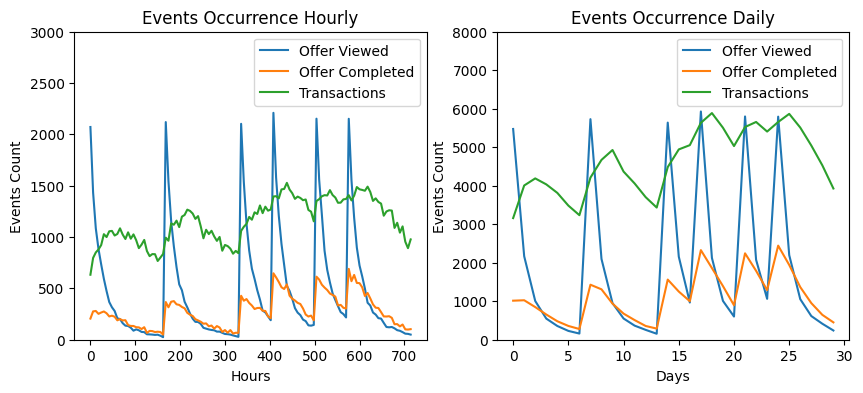

In [39]:
# Visualize
hours = viewed_hourly.index.values
fig, axs = plt.subplots(1,2, figsize = (10, 4))
axs[0].plot(hours, viewed_hourly)
axs[0].plot(hours, completed_hourly)
axs[0].plot(hours, transaction_hourly)
axs[0].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1)
axs[0].set_ylim([0, 3000])
axs[0].set_xlabel('Hours')
axs[0].set_ylabel('Events Count')
axs[0].set_title('Events Occurrence Hourly')

days = np.arange(30)
axs[1].plot(days, viewed_daily)
axs[1].plot(days, completed_daily)
axs[1].plot(days, transaction_daily)
axs[1].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1)
axs[1].set_ylim([0, 8000])
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Events Count')
axs[1].set_title('Events Occurrence Daily')

plt.show()

Offer completion was highly correlated with offer viewing. In the hourly subplot, peaks in offer viewing are consistently followed by peaks in offer completion with only a short time lag, indicating that customers who click on an offer tend to use it within hours. This observation is reinforced by the daily subplot, where peaks in offer viewing and completion align closely, showing that many customers complete the offer on the same day they view it.

Transactions also correlate with offer viewing and completion, but they exhibit a more spread-out pattern. An interesting phenomenon is observed when comparing offer completion and transactions: after each peak in offer viewing, offer completion peaks quickly (within hours), while transactions continue to rise and peak about two days later. This suggests that the offers not only drove immediate purchases but also contributed to shaping customers' purchasing habits (although temporarily).


**Recommendation:**
Offers not only generate direct revenue but also enhance customer loyalty. Given that the impact of each individual offer is temporary, the company should distribute offers at regular intervals to help establish and reinforce purchasing habits among customers.

## **Most popular offers & What made them popular?**

Completing an offer involves two steps: viewing it and then completing it. Therefore, the overall completion rate is determined by two metrics:

- **View rate**: The ratio of offers viewed to offers received.
- **Completion rate**: The ratio of offers completed to offers viewed.

In this section, I will address the following questions:

- Which offers were the most popular (archived the highest overall completion rate)?
- What is the most significant factor contributing to the view rate?
- What is the most significant factor contributing to the completion rate?

### **Which offers were the most popular?**

In [40]:
# Create a df that only contains events about offers
df_event = df_transcript[~(df_transcript['event'] == 'transaction')]

# Merge df_event with and offers, then drop column `dict_value`, because this information is provided in column `offer_alias`
event_offer = pd.merge(df_event, df_offer, left_on = 'dict_value', right_on = 'id').drop(['id', 'dict_value'], axis = 1)
event_offer.sample(3)

,person,event,time,dict_key,days_since_start,reward,channels,difficulty,duration,offer_type,offer_alias
88057,0ecc8a63f8ce437aaec064b14cd5813f,offer received,168,offer id,7,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,B
54264,e2415c178a064a36b1081c2816f75e19,offer viewed,342,offer id,14,2,"['web', 'email', 'mobile', 'social']",10,10,discount,F
31099,9f1114fcf9f54508a4887d4ac0dc130c,offer received,0,offer id,0,2,"['web', 'email', 'mobile']",10,7,discount,G


**Overall Completion Rate %**

In [41]:
# Count the number of times each offer was received
offer_received = pd.DataFrame(event_offer[event_offer['event'] == 'offer received'].value_counts('offer_alias')\
                              .sort_values(ascending = False)).rename(columns = {'count': 'received_cnt'})
print(offer_received)
# Count the number of times each offer was completed
offer_completed = pd.DataFrame(event_offer[event_offer['event'] == 'offer completed'].value_counts('offer_alias')\
                               .sort_values(ascending = False)).rename(columns = {'count': 'completed_cnt'})
print(offer_completed)

             received_cnt
offer_alias              
A                    7677
H                    7668
C                    7658
E                    7646
G                    7632
J                    7618
I                    7617
F                    7597
D                    7593
B                    7571
             completed_cnt
offer_alias               
F                     5317
E                     5156
A                     4354
B                     4296
G                     4017
C                     3688
H                     3420
D                     3331


In [42]:
overall_complete_rate = pd.merge(offer_received, offer_completed, on = 'offer_alias')
overall_complete_rate['rate'] = overall_complete_rate['completed_cnt']/overall_complete_rate['received_cnt']
overall_complete_rate = overall_complete_rate.sort_values('rate', ascending = False)
overall_complete_rate

,received_cnt,completed_cnt,rate
offer_alias,,,
F,7597,5317,0.699882
E,7646,5156,0.674340
B,7571,4296,0.567428
A,7677,4354,0.567149
G,7632,4017,0.526336
C,7658,3688,0.481588
H,7668,3420,0.446009
D,7593,3331,0.438694


All 10 offers were received nearly the same number of times, around 7,600, during the campaign month.

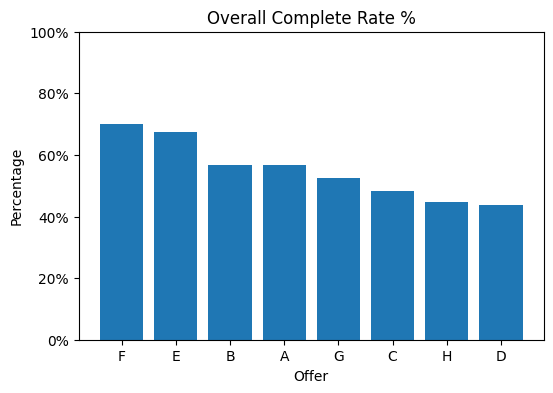

In [43]:
plt.figure(figsize=(6,4))
plt.bar(x = overall_complete_rate.index.values, height = overall_complete_rate['rate'])
plt.title('Overall Complete Rate %')
plt.xlabel('Offer')
plt.ylabel('Percentage')
plt.yticks(np.arange(0, 1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

The top 3 most popular offers were Offer F, Offer E, and Offer B, with overall completion rates of 70%, 67.4%, and 56.7%, respectively. The least popular offer was Offer D, which had an overall completion rate of approximately 44%.

### **What is the most significant factor contributing to the view rate?**

In [44]:
offer_view = pd.DataFrame(event_offer[event_offer['event'] == 'offer viewed'].value_counts('offer_alias')\
                              .sort_values(ascending = False)).rename(columns = {'count': 'view_cnt'})

view_rate = pd.merge(offer_received, offer_view, on = 'offer_alias')
view_rate['view_rate'] = view_rate['view_cnt']/view_rate['received_cnt']
view_rate = view_rate.sort_values('view_rate', ascending = False)
view_rate

,received_cnt,view_cnt,view_rate
offer_alias,,,
F,7597,7327,0.964460
D,7593,7298,0.961148
E,7646,7337,0.959587
B,7571,7264,0.959451
J,7618,6687,0.877789
C,7658,6716,0.876991
I,7617,4144,0.544046
A,7677,4171,0.543311
G,7632,4118,0.539570


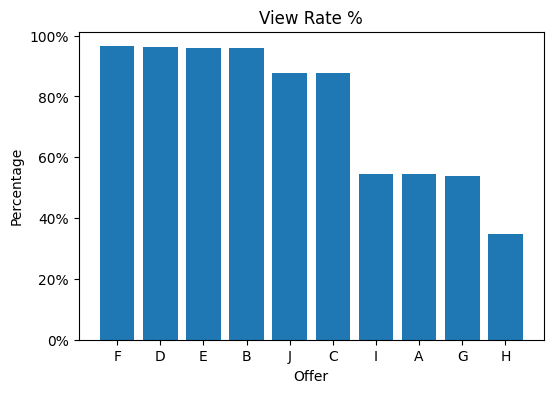

In [45]:
plt.figure(figsize=(6,4))
plt.bar(x = view_rate.index.values, height = view_rate['view_rate'])
plt.title('View Rate %')
plt.xlabel('Offer')
plt.ylabel('Percentage')
plt.yticks(np.arange(0, 1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

The bar chart shows the 10 offers grouped into 4 distinct height levels, which correspond to 4 different combinations of promotional channels, as shown below:

In [46]:
df_offer[['offer_alias','channels']].sort_values('channels')

,offer_alias,channels
2,C,"['email', 'mobile', 'social']"
9,J,"['email', 'mobile', 'social']"
1,B,"['web', 'email', 'mobile', 'social']"
3,D,"['web', 'email', 'mobile', 'social']"
4,E,"['web', 'email', 'mobile', 'social']"
5,F,"['web', 'email', 'mobile', 'social']"
0,A,"['web', 'email', 'mobile']"
6,G,"['web', 'email', 'mobile']"
8,I,"['web', 'email', 'mobile']"
7,H,"['web', 'email']"


**Group 1:** `['web', 'email', 'mobile', 'social']`

**Group 2:** `['email', 'mobile', 'social']`

**Group 3:** `['web', 'email', 'mobile']`

**Group 4:** `['web', 'email']`

------
When comparing the effects of different promotion channels:

- Group 1 vs. Group 2: Offers from websites had a minimal impact on the view rate, with Group 1 showing a slightly higher view rate overall.
- Group 2 vs. Group 3: Group 2 has a significantly higher view rate. Offers from social media contributed significantly to this view rate.
- Group 3 vs. Group 4: Group 3 has a notably higher view rate. Offers received via mobile app contributed moderately to the view rate.
- Group 4 alone (Email, considering Web): Reducing the effect of web offers, it is clear that most offers in Group 4 were viewed through email. As web offers have minimal impact, email offers had a substantial contribution to the view rate, slightly more than mobile offers.

### **Conclusion**
- Offers sent through the same promotion channels showed very similar view rates, regardless of variations in other factors such as offer type, duration, reward, and difficulty. This suggests that the **promotion channel is the most significant, if not sole, factor influencing the offer view rate.**
- Social media and email were the most effective channels in driving offer views, with mobile also contributing significantly. The web had the least impact on view rates.

### **What is the most significant factor contributing to the completion rate?**

In [47]:
overall_complete_rate = pd.merge(overall_complete_rate, offer_view, on = 'offer_alias')
overall_complete_rate['view_to_complete'] = overall_complete_rate['completed_cnt']/overall_complete_rate['view_cnt']
overall_complete_rate = overall_complete_rate.sort_values('view_to_complete', ascending = False)
overall_complete_rate

,received_cnt,completed_cnt,rate,view_cnt,view_to_complete
offer_alias,,,,,
H,7668,3420,0.446009,2663,1.284266
A,7677,4354,0.567149,4171,1.043874
G,7632,4017,0.526336,4118,0.975474
F,7597,5317,0.699882,7327,0.725672
E,7646,5156,0.674340,7337,0.702740
B,7571,4296,0.567428,7264,0.591410
C,7658,3688,0.481588,6716,0.549136
D,7593,3331,0.438694,7298,0.456426


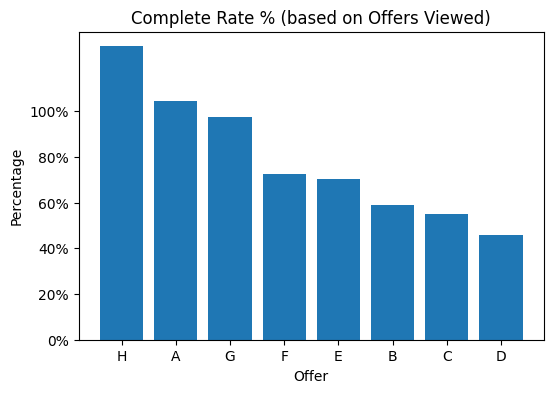

In [48]:
plt.figure(figsize=(6,4))
plt.bar(x = overall_complete_rate.index.values, height = overall_complete_rate['view_to_complete'])
plt.title('Complete Rate % (based on Offers Viewed)')
plt.xlabel('Offer')
plt.ylabel('Percentage')
plt.yticks(np.arange(0, 1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

In [49]:
df_offer[['offer_alias','offer_type']].sort_values('offer_type')

,offer_alias,offer_type
0,A,bogo
1,B,bogo
2,C,bogo
3,D,bogo
4,E,discount
5,F,discount
6,G,discount
7,H,discount
8,I,informational
9,J,informational


- For offers that were viewed, completion rates ranged from 46% to 128%. Notably, Offers H and A achieved completion rates over 100%, indicating that, on average, these offers were completed by customers more than once.
- Among the top 5 offers with the highest completion rates, all are of the 'discount' type, with Offer A being the sole exception. This suggests that **customers preferred 'discount' offers over 'bogo' offers**.

Therefore, the primary factor influencing the offer completion rate is the offer type, with 'Discount' offers being more effective than 'bogo' offers.

# **Section Summary**

The three questions proposed at the beginning of the section have been addressed:

- The most popular offers were F, E, and B, with overall completion rates of 70%, 67.4%, and 56.7%, respectively.
- The primary contributor to view rate was the promotion channel, ranked in effectiveness as: Social Media > Email >= Mobile > Company Website.
- The key factor affecting the completion rate was the offer type. Customers preferred 'discount' offers over 'bogo' offers.

### **Suggestions**

The company should aim to send offers through as many channels as possible. However, if the budget is limited, social media should be prioritized, as it is the most effective channel for offer views. Additionally, 'discount' offers should be used, as they result in higher completion rates.

# **Customer Segmentation**

In this section, customers will be segmented based on their transactional behavior during the campaign month. The features extracted for this analysis include the number of offers viewed, offers completed, transactions made, and total spending. K-Means clustering will be applied for segmentation, with the Elbow method and Silhouette scores used to determine the optimal number of clusters (k).

The clustering results will be evaluated to check whether they make business sense. Key metrics will be calculated for each cluster for interpretation, including Average Purchase Value (APV), purchase frequency, overall offer completion rate, and sensitivity to offers. This will provide a comprehensive understanding of customer behavior within each segment.

Lastly, the demographic profile of each cluster will be examined.

## **Extracting Customer Behavior Features**

In [50]:
# Remove rows of customers with missing gender and income
transcripts_filtered = df_transcript[~df_transcript['person'].isin(missing_income['id'])].reset_index(drop = True)

# Aggregate df `transcripts`
transcripts_filtered = transcripts_filtered.sort_values('person')
transcripts_grouped = transcripts_filtered.groupby(['person', 'event']).count()
transcripts_grouped.head(10)

time  dict_key  dict_value  \
person                           event                                         
0009655768c64bdeb2e877511632db8f offer completed     3         3           3   
                                 offer received      5         5           5   
                                 offer viewed        4         4           4   
                                 transaction         8         8           8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed     3         3           3   
                                 offer received      5         5           5   
                                 offer viewed        5         5           5   
                                 transaction         5         5           5   
0020c2b971eb4e9188eac86d93036a77 offer completed     3         3           3   
                                 offer received      5         5           5   

                                                  days_since_start  
person                           event                              
0009655768c64bdeb2e877511632db8f offer completed                 3  
                                 offer received                  5  
                                 offer viewed                    4  
                                 transaction                     8  
0011e0d4e6b944f998e987f904e8c1e5 offer completed                 3  
                                 offer received                  5  
                                 offer viewed                    5  
                                 transaction                     5  
0020c2b971eb4e9188eac86d93036a77 offer completed                 3  
                                 offer received                  5

In [51]:
customer_behavior = pd.pivot_table(transcripts_grouped, values = 'dict_key', index = 'person', columns = 'event')

customer_behavior.rename(columns = {'offer completed': 'num_completed',
                                    'offer received': 'num_received',
                                    'offer viewed': 'num_viewed',
                                    'transaction': 'num_transactions'
                                    }, inplace = True)
customer_behavior.head()

event,num_completed,num_received,num_viewed,num_transactions
person,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0


In [52]:
# Calculate how much money each customer spent
customer_behavior['money_spent'] = transcripts_filtered[transcripts_filtered['event'] == 'transaction'].groupby('person')['dict_value'].sum()
customer_behavior.head(3)

event,num_completed,num_received,num_viewed,num_transactions,money_spent
person,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,127.6
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,79.46
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,196.86


In [53]:
customer_behavior.isna().sum()

,0
event,
num_completed,2839
num_received,5
num_viewed,150
num_transactions,333
money_spent,333


The NAs will be replaced with 0, indicating that these customers received, viewed, or completed zero offers, or made zero transactions.

In [54]:
# Replace NA with 0
customer_behavior.fillna(0, inplace = True)
customer_behavior.isna().sum()

,0
event,
num_completed,0
num_received,0
num_viewed,0
num_transactions,0
money_spent,0


In [55]:
customer_behavior.head()

event,num_completed,num_received,num_viewed,num_transactions,money_spent
person,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,127.60
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,79.46
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,196.86
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,154.05
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0,48.34


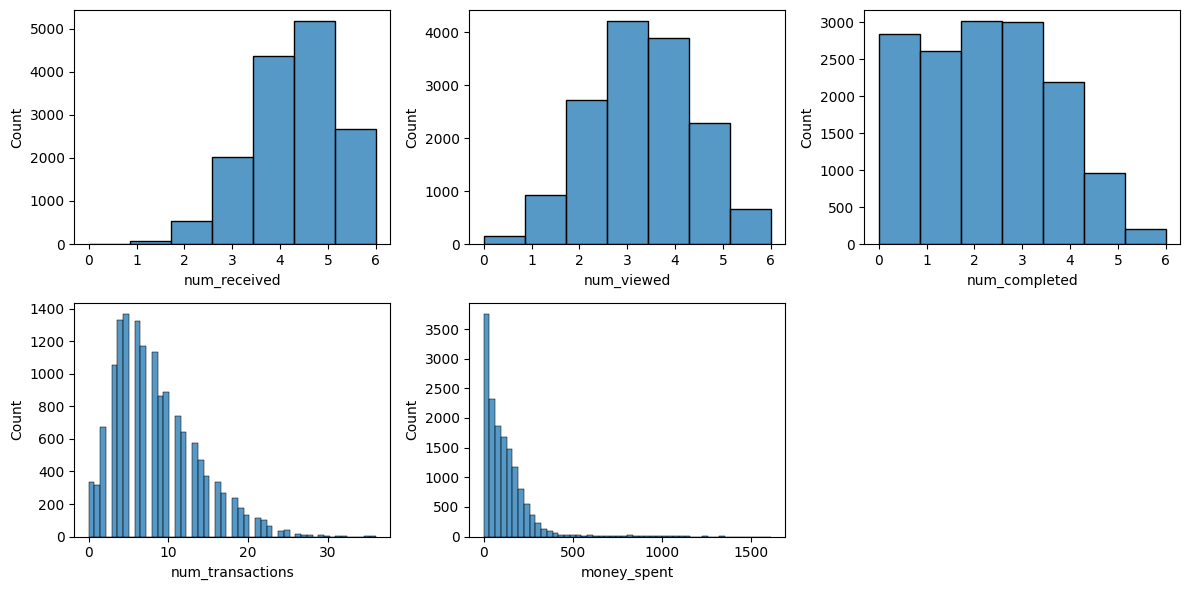

In [56]:
fig, axs = plt.subplots(2, 3, figsize = (12,6))
sns.histplot(data = customer_behavior, x = 'num_received', bins = customer_behavior['num_received'].astype('int').max()+1, ax = axs[0,0])
sns.histplot(data = customer_behavior, x = 'num_viewed', bins = customer_behavior['num_viewed'].astype('int').max()+1, ax = axs[0,1])
sns.histplot(data = customer_behavior, x = 'num_completed', bins = customer_behavior['num_completed'].astype('int').max()+1, ax = axs[0,2])
sns.histplot(data = customer_behavior, x = 'num_transactions', bins = 50, ax = axs[1,0])
sns.histplot(data = customer_behavior, x = 'money_spent', bins = 50, ax = axs[1,1])

axs[1,2].set_axis_off()
plt.tight_layout()
plt.show()

**Preparing df `customer_behavior` for clustering**

Since customers did not actively choose how many offers they received, I will exclude this feature from the clustering analysis.

In [57]:
# Drop `num_received`
customer_behavior.drop('num_received', axis = 1, inplace = True)

From the plots above, the feature `money_spent` appears to be skewed by outliers.

In [58]:
customer_behavior['money_spent'].describe()

,money_spent
count,14825.000000
mean,117.028155
std,129.965016
min,0.000000
25%,31.450000
50%,87.040000
75%,160.900000
max,1608.690000


The 75th percentile is around $160, while the maximum value is ten times higher. I will remove the top 2% of records in terms of money_spent before running the K-Means clustering. Note that these high-value customers will be handled separately. After clustering the remaining customers, they will either be assigned to an appropriate cluster or form their own distinct cluster.

In [59]:
q = customer_behavior['money_spent'].quantile(0.98)
top_2_customers = customer_behavior[customer_behavior['money_spent'] >= q]
person_top_2 = top_2_customers.index.values

# Remove rows with top 2% in `money_spent`
customer_behavior_filtered = customer_behavior[customer_behavior['money_spent'] < q]

## **K-Means Clustering**

**Feature Scaling**

In [60]:
scaler = StandardScaler()
scaler.fit(customer_behavior_filtered)
customer_behavior_scaled = scaler.transform(customer_behavior_filtered)
pd.DataFrame(data = customer_behavior_scaled, columns = customer_behavior_filtered.columns.values).head(3)

,num_completed,num_viewed,num_transactions,money_spent
0,0.531352,0.501233,-0.060069,0.277234
1,0.531352,1.276977,-0.639666,-0.281415
2,0.531352,-0.274511,-0.060069,1.080974


**Optimal Number of Clusters K**

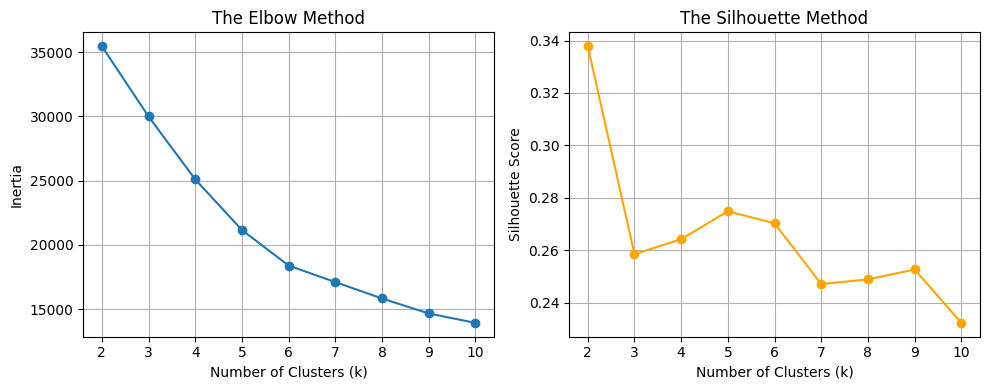

In [61]:
max_k = 10

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_behavior_scaled)
    sil_score = metrics.silhouette_score(customer_behavior_scaled, cluster_labels)
    silhoutte_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('The Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

From the Elbow graph, it can be observed that at k = 5, the Inertia starts to decrease at a slower rate. Similarly, the Silhouette graph shows a maximum at k = 5 (excluding k = 2).

While 5 segments may seem like a large number, if the clusters demonstrate clear differences in their features, the results should still be interpretable. Therefore, k = 5 will be selected for the K-Means clustering analysis.

**K-Means Clustering**

In [62]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit_transform(customer_behavior_scaled)
customer_with_cluster = customer_behavior_filtered.assign(cluster = kmeans.labels_)
print(customer_with_cluster.value_counts('cluster').sort_index())

print('\n', '-'*60)
print('Silhouette Score:', metrics.silhouette_score(customer_behavior_scaled, labels = kmeans.labels_))

cluster_info = customer_with_cluster.groupby('cluster').mean()
print('\n', '-'*60)
print(cluster_info.round(1))

cluster
0    3367
1    2925
2    2642
3    4007
4    1587
Name: count, dtype: int64

 ------------------------------------------------------------
Silhouette Score: 0.27485471740745754

 ------------------------------------------------------------
event    num_completed  num_viewed  num_transactions  money_spent
cluster                                                          
0                  2.9         2.8               7.7        139.4
1                  4.1         4.4              12.2        222.8
2                  1.5         4.5               4.5         50.2
3                  0.7         2.1               5.0         34.4
4                  2.0         3.5              17.1         72.4


**Clustering Result Visualization & Interpretation**

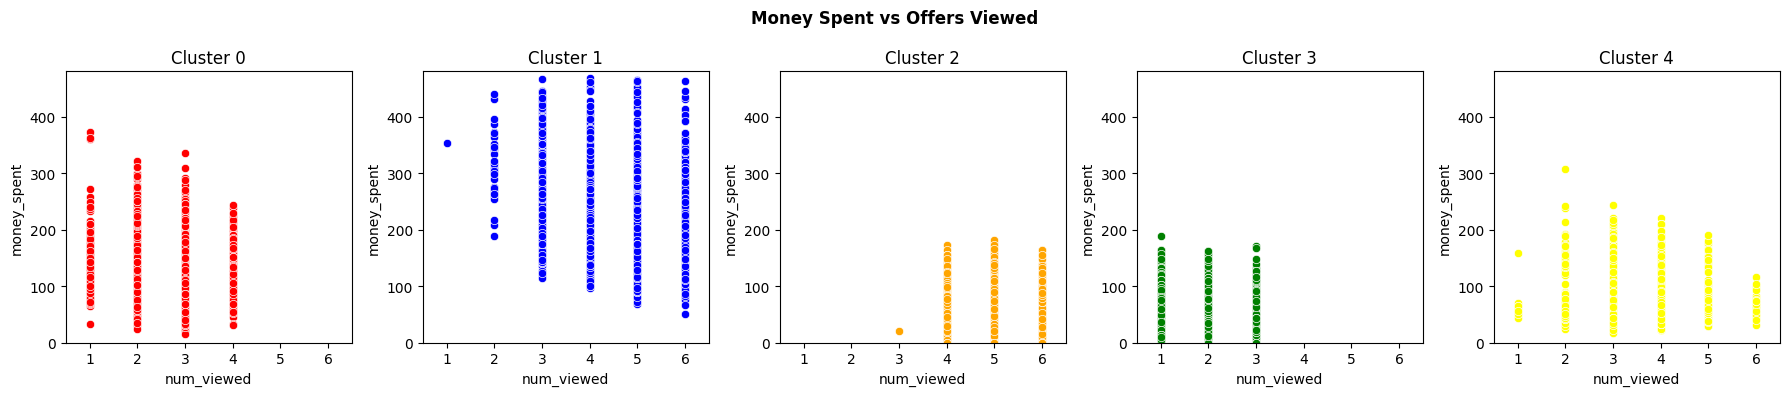

In [63]:
color_list = ['red', 'blue', 'orange', 'green', 'yellow']
fig, axs = plt.subplots(1, 5, figsize = (18,4))
for i in range(5):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'money_spent', color = color_list[i], ax = axs[i])

    axs[i].set_title('Cluster ' + str(i))
    axs[i].set_xlim((0.5,6.5))
    axs[i].set_ylim((0,480))
fig.suptitle('Money Spent vs Offers Viewed', fontweight = 'bold')
plt.tight_layout()
plt.show()

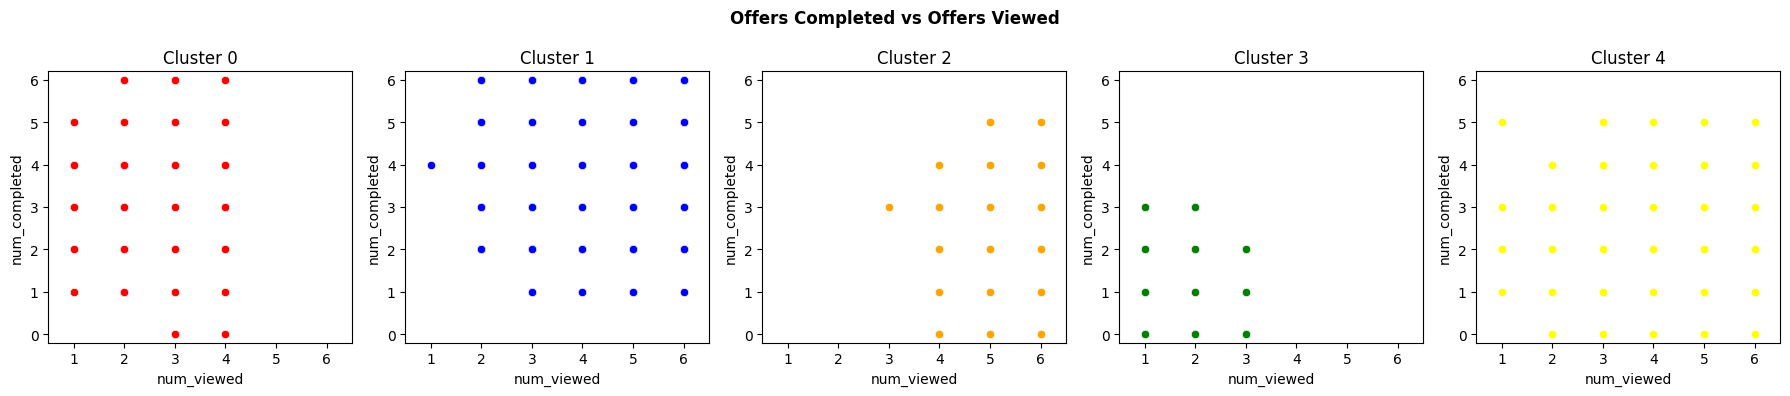

In [64]:
fig, axs = plt.subplots(1, 5, figsize = (18,4))
for i in range(5):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'num_completed', color = color_list[i], ax = axs[i])

    axs[i].set_title('Cluster ' + str(i))
    axs[i].set_xlim((0.5,6.5))
    axs[i].set_ylim((-0.2,6.2))
fig.suptitle('Offers Completed vs Offers Viewed', fontweight = 'bold')
plt.tight_layout()
plt.show()

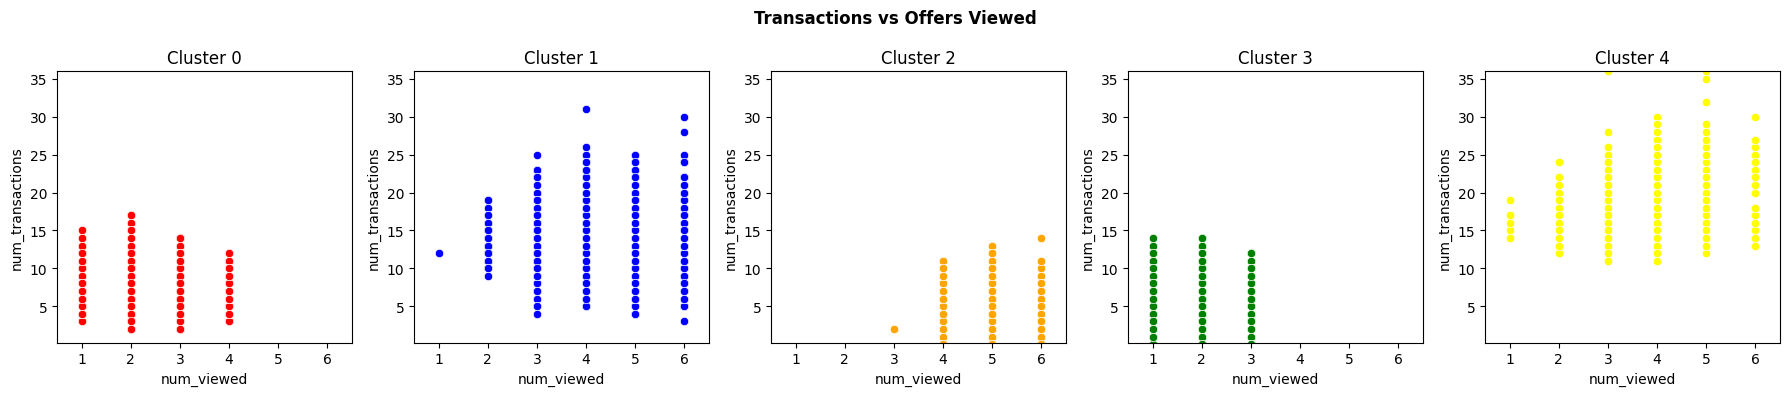

In [65]:
fig, axs = plt.subplots(1, 5, figsize = (18,4))
for i in range(5):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'num_transactions', color = color_list[i], ax = axs[i])

    axs[i].set_title('Cluster ' + str(i))
    axs[i].set_xlim((0.5,6.5))
    axs[i].set_ylim((0.2,36))
fig.suptitle('Transactions vs Offers Viewed', fontweight = 'bold')
plt.tight_layout()
plt.show()

**Key Metrics of each cluster**

To better understand the behaviors of each segment and to inform segment-specific strategies, the following key metrics will be used:

- **Frequency:** The number of transactions made during the campaign month.
- **Average Purchase Value (APV):** The average amount spent per transaction.
- **Offer Completion Rate:** The ratio of offers completed to offers viewed.
- **Sensitivity to Offers:** The proportion of transactions made using offers, calculated as the ratio of `num_completed` to `num_transactions`.

In [66]:
cluster_info

event,num_completed,num_viewed,num_transactions,money_spent
cluster,,,,
0,2.881497,2.841699,7.701515,139.416020
1,4.089915,4.441368,12.207863,222.814113
2,1.459122,4.542771,4.526117,50.231113
3,0.666833,2.143748,4.993511,34.430614
4,2.029616,3.512287,17.098299,72.389288


In [67]:
# Add columns to df `cluster_info`
cluster_info['frequency'] = cluster_info['num_transactions'].round(1)
cluster_info['avg_purchase_value'] = (cluster_info['money_spent'] / cluster_info['num_transactions']).round(1)
cluster_info['offer_complete_rate'] = (cluster_info['num_completed'] / cluster_info['num_viewed']).round(2)
cluster_info['offer_sensitivity'] = (cluster_info['num_completed'] / cluster_info['num_transactions']).round(2)

cluster_info = cluster_info[['frequency', 'avg_purchase_value', 'offer_complete_rate', 'offer_sensitivity']]
cluster_info.head()

event,frequency,avg_purchase_value,offer_complete_rate,offer_sensitivity
cluster,,,,
0,7.7,18.1,1.01,0.37
1,12.2,18.3,0.92,0.34
2,4.5,11.1,0.32,0.32
3,5.0,6.9,0.31,0.13
4,17.1,4.2,0.58,0.12


### **Interpretation of the Clustering Results**

**Cluster 1 – Most Valuable Customers**  
- Customers in this cluster are highly valuable due to their frequent purchases (12.2 on average, around one purchase every 2-3 days) and high spending, with the highest **APV** of $18.3. Their **Offer Completion Rate** is high (92%), and they show a moderate level of **Offer Sensitivity** (34%), meaning they respond well to offers but are not overly reliant on them.
- These customers generate significant revenue and should be prioritized for retention strategies. The company can further engage them by encouraging more frequent purchases, perhaps through exclusive promotions.

**Cluster 0 – Responsive Purchasers**  
- Customers in this cluster make frequent purchases (7.7 on average) with a high **APV** of $18.1. They have the highest **Offer Completion Rate** of 100%, indicating that, on average, they used every offer they viewed, showing strong responsiveness to offers. Their **Offer Sensitivity** is moderate (37%), suggesting they often use offers to make purchases.
- These customers are valuable due to their responsiveness, and the company should continue targeting them with well-tailored offers to maintain engagement.

**Cluster 2 – Moderate Spending, Moderate Engagement**  
- Cluster 2 customers make fewer purchases (4.5 on average) and have a lower **APV** of $11.1. Their **Offer Completion Rate** is low at 32%, and their **Offer Sensitivity** is similar at 32%, indicating they are less likely to use offers for their purchases.
- This group may need stronger incentives or better-targeted offers to increase engagement, as they are less influenced by existing promotions and spend less per transaction.

**Cluster 3 – Occasional Low-Spenders**  
- Customers in this cluster make only 5 purchases on average and have the lowest **APV** of $6.9. They are the least responsive to offers, with both an **Offer Completion Rate** and **Offer Sensitivity** of 31% and 13%, respectively.
- These customers are less engaged with both offers and purchasing overall. The company could focus on nurturing this group by offering significant discounts or more personalized offers to increase both their purchase frequency and spend.

**Cluster 4 – Regulars**  
- This cluster consists of the company’s most frequent purchasers, with an average of 17.1 transactions during the campaign, showing strong loyalty. However, they have the lowest **APV** of $4.2, indicating they consistently make low-value purchases. Their **Offer Completion Rate** is moderate at 58%, but their **Offer Sensitivity** is very low at 12%, showing that offers do not significantly drive their purchasing behavior.
- These regular customers are crucial for stable revenue, but the company could focus on increasing their **APV** by encouraging them to try higher-value products through targeted promotions or sampling programs.

**Customer Demographics of Each Cluster**

Recall that the top 2% of customers in terms of money_spent were excluded from clustering. I will check if they all belong to the Most Valuable Customers (Cluster 1) and assign them to the appropriate cluster for further analysis.

In [68]:
top_2_customers_scaled = scaler.transform(top_2_customers)
kmeans.predict(top_2_customers_scaled)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int3

In [69]:
unique, counts = np.unique(kmeans.predict(top_2_customers_scaled), return_counts=True)
occurrences = dict(zip(unique, counts))

print(occurrences)

{0: 2, 1: 295}


Because 295/297 customers who spent top 2% belong to cluster 1, I will then add all of them to cluster 1 for simplicity.

In [70]:
# Concatenate top 2% with the rest of the customers
customer_behavior_clustered = pd.concat([customer_with_cluster, top_2_customers], axis = 0)

# Assign these customers to cluster 1
customer_behavior_clustered['cluster'].fillna(1, inplace = True)

# Convert cluster label from float to integer
customer_behavior_clustered['cluster'] = customer_behavior_clustered['cluster'].astype('int')

Merge `customer_behavior_clustered` with `customers`

In [71]:
customer_behavior_clustered.reset_index(inplace = True)

# Merge
customer_behavior_profile = pd.merge(customer_behavior_clustered, df_customer_no_na,
                                    left_on = 'person', right_on = 'id').drop(['id'], axis = 1)
customer_behavior_profile.head()

,person,num_completed,num_viewed,num_transactions,money_spent,cluster,gender,age,became_member_on,income,age_group,income_group
0,0009655768c64bdeb2e877511632db8f,3.0,4.0,8.0,127.60,0,M,33,2017-04-21,72000.0,26-35,60-75k
1,0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,79.46,2,O,40,2018-01-09,57000.0,36-45,45-60k
2,0020c2b971eb4e9188eac86d93036a77,3.0,3.0,8.0,196.86,0,F,59,2016-03-04,90000.0,56-65,75-90k
3,0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,12.0,154.05,1,F,24,2016-11-11,60000.0,18-25,45-60k
4,003d66b6608740288d6cc97a6903f4f0,3.0,4.0,18.0,48.34,4,F,26,2017-06-21,73000.0,18-25,60-75k


In [72]:
# Add column `cluster_alias`
customer_behavior_profile['cluster_alias'] = customer_behavior_profile['cluster'].map({0: 'Responsive-Purchasers',
                                                                                       1: 'Most-Valuable',
                                                                                       2: 'Moderate-Spenders',
                                                                                       3: 'Low-Spenders',
                                                                                       4: 'Regulars'
                                                                                       })
customer_behavior_profile.head(3)

,person,num_completed,num_viewed,num_transactions,money_spent,cluster,gender,age,became_member_on,income,age_group,income_group,cluster_alias
0,0009655768c64bdeb2e877511632db8f,3.0,4.0,8.0,127.60,0,M,33,2017-04-21,72000.0,26-35,60-75k,Responsive-Purchasers
1,0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,79.46,2,O,40,2018-01-09,57000.0,36-45,45-60k,Moderate-Spenders
2,0020c2b971eb4e9188eac86d93036a77,3.0,3.0,8.0,196.86,0,F,59,2016-03-04,90000.0,56-65,75-90k,Responsive-Purchasers


In [73]:
print(customer_behavior_profile.value_counts('cluster'))
print('\n', '-'*50)
print(customer_behavior_profile.value_counts('cluster', normalize=True))

cluster
3    4007
0    3367
1    3222
2    2642
4    1587
Name: count, dtype: int64

 --------------------------------------------------
cluster
3    0.270287
0    0.227116
1    0.217336
2    0.178212
4    0.107049
Name: proportion, dtype: float64


In [74]:
(customer_behavior_profile.groupby('cluster_alias')[['age', 'income']].mean()).round(2)

,age,income
cluster_alias,,
Low-Spenders,52.07,59315.45
Moderate-Spenders,55.53,65190.76
Most-Valuable,56.05,71707.95
Regulars,47.33,48791.43
Responsive-Purchasers,58.02,74619.25


The **Responsive-Purchasers** segment has the highest age and income, followed closely by the **Most-Valuable** segment. On the other hand, the **Regulars** segment is the lowest in both age and income, indicating that regular purchases don't necessarily correlate with higher financial status or older age.

**Gender distribution in each segment**

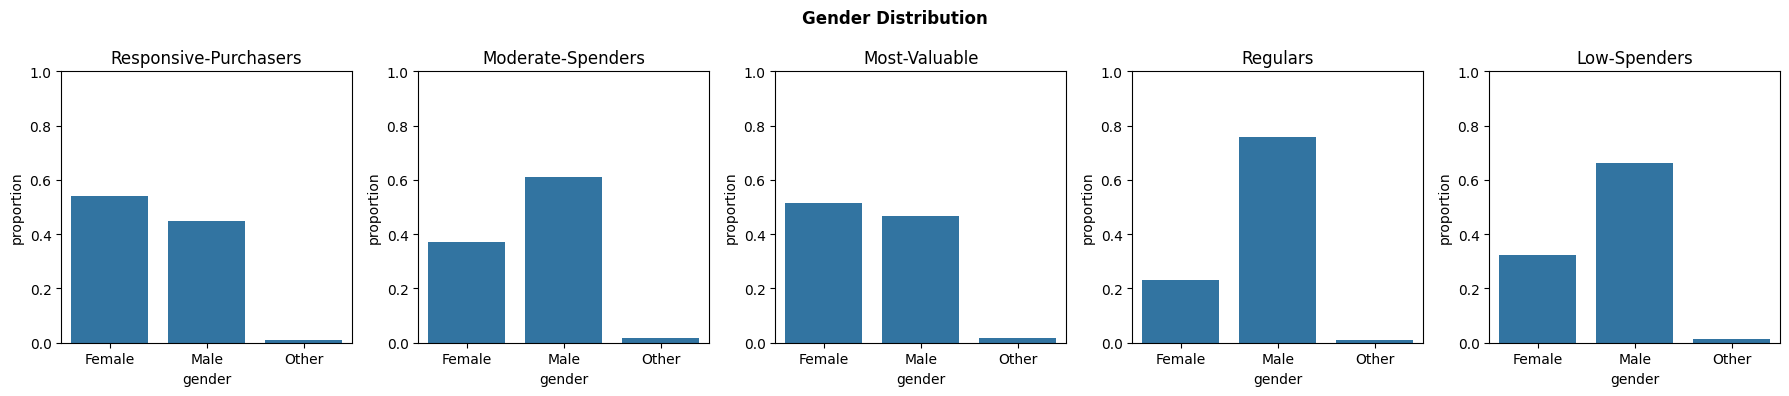

In [75]:
fig, axs = plt.subplots(1,5, figsize = (18,4))
for i, cluster in enumerate(customer_behavior_profile['cluster_alias'].unique()):
  sns.barplot(customer_behavior_profile[customer_behavior_profile['cluster_alias'] == cluster].value_counts('gender', normalize=True).sort_index(), ax = axs[i])
  axs[i].set_title(cluster)
  axs[i].set_xticklabels(['Female', 'Male', 'Other'])
  axs[i].set_yticks(np.arange(0, 1.2, 0.2))

plt.suptitle('Gender Distribution', fontweight = 'bold')
plt.tight_layout()
plt.show()

**Age distribution in each segment**

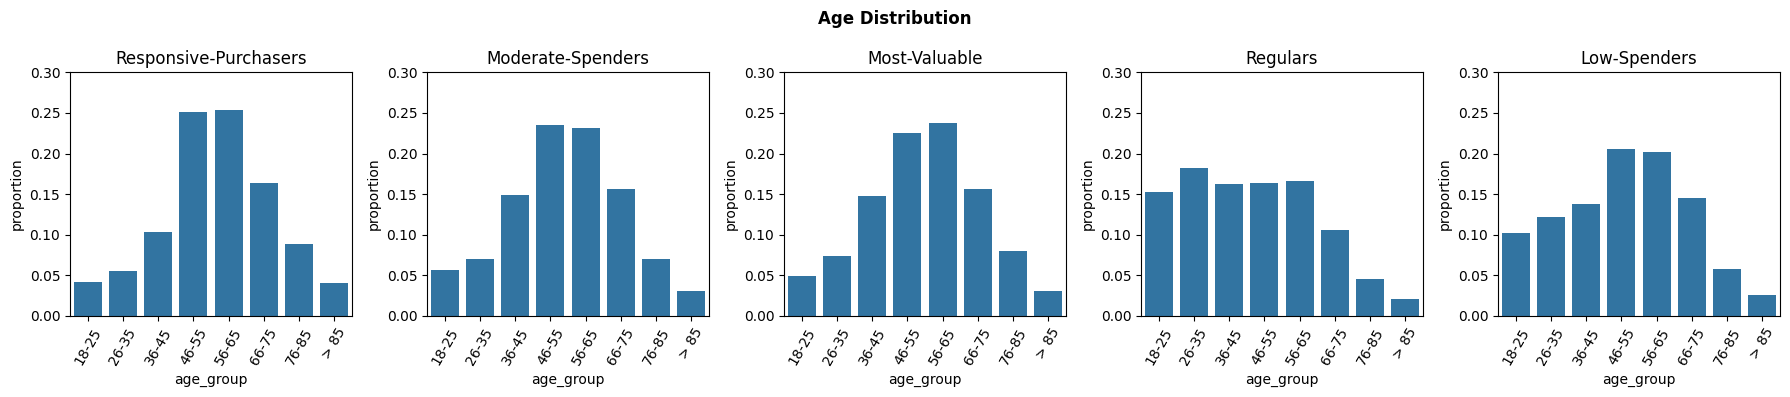

In [76]:
fig, axs = plt.subplots(1,5, figsize = (18,4))
for i, cluster in enumerate(customer_behavior_profile['cluster_alias'].unique()):
  sns.barplot(customer_behavior_profile[customer_behavior_profile['cluster_alias'] == cluster].value_counts('age_group', normalize=True).sort_index(), ax = axs[i])
  axs[i].set_title(cluster)
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
  axs[i].set_yticks(np.arange(0, 0.35, 0.05))

plt.suptitle('Age Distribution', fontweight = 'bold')
plt.tight_layout()
plt.show()

**Income distribution in each segment**

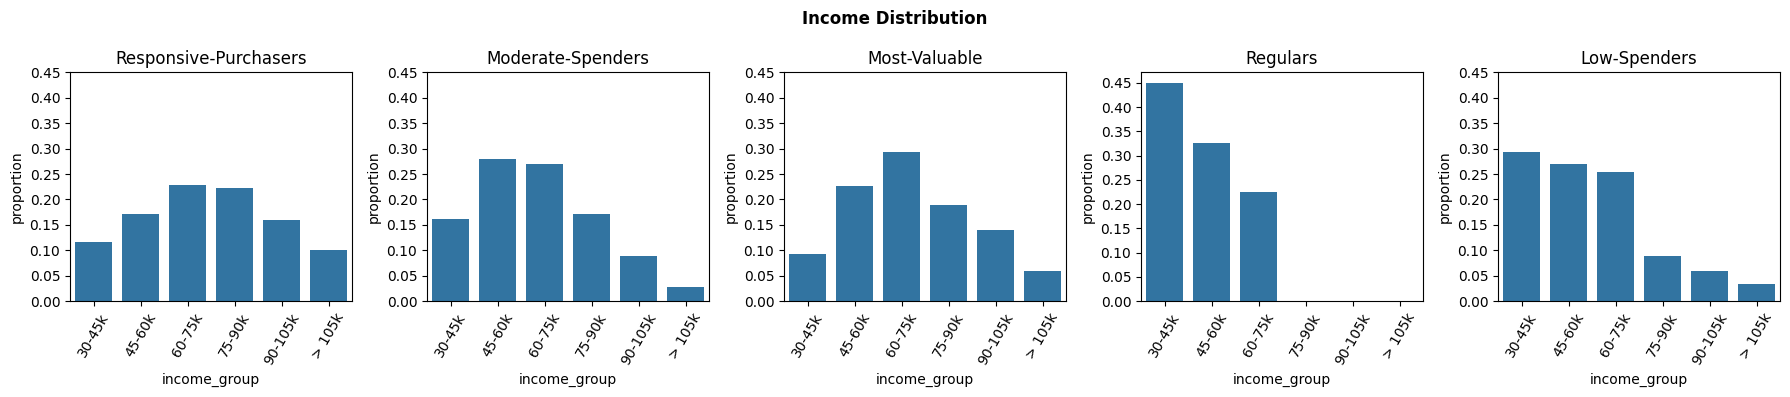

In [77]:
fig, axs = plt.subplots(1,5, figsize = (18,4))
for i, cluster in enumerate(customer_behavior_profile['cluster_alias'].unique()):
  sns.barplot(customer_behavior_profile[customer_behavior_profile['cluster_alias'] == cluster].value_counts('income_group', normalize=True).sort_index(), ax = axs[i])
  axs[i].set_title(cluster)
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
  axs[i].set_yticks(np.arange(0, 0.5, 0.05))

plt.suptitle('Income Distribution', fontweight = 'bold')
plt.tight_layout()
plt.show()

### **Demographic Summary of Each Segment**

1. **Responsive-Purchasers**: Skewed older, with 66% aged 46-65 and 45.9% earning 60k-90k. Mostly female (54%).

2. **Moderate-Spenders**: Middle-income group, with 55% earning 45k-75k. Skewed older, with 47% aged 46-65. Mostly male (61%).

3. **Most-Valuable**: Similar to Responsive-Purchasers, with 48% earning 60k-90k and 46% aged 46-65. Fairly balanced gender distribution, with 51% female and 47% male.

4. **Regulars**: Younger, lower-income group. Nearly half (45%) earn 30k-45k, with 34% under 35. Mostly male (76%).

5. **Low-Spenders**: Lower-middle income, with 57% earning 30k-60k. Balanced across age groups, with 34% aged 46-65 and 22% under 35. Mostly male (66%).

**Key Insights:**
- **Responsive-Purchasers** and **Most-Valuable** are older and wealthier, with balanced gender ratios.
- **Regulars** are younger, lower-income, and heavily skewed towards male customers.
- **Low-Spenders** and **Moderate-Spenders** also show male dominance but have a broader spread across income and age groups.